<a href="https://colab.research.google.com/github/wangyaomoon/Cooling-Stage/blob/main/DeepCGH_tutorial_Yao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DeepCGH: 3D computer generated holography using deep learning**

This notebook shows a simple implementation, training and testing of DeepCGH, our new algorithm for 3D Computer Generated Holography with Deep learning.

Step 1 - We clone our code from github, and generate a training dataset that consists of randomly distributed Disks.

Step 2 - We use this dataset to run train our DeepCGH model (here, to save time, we load from github a pretrained model (20 epochs) and we just add one epoch).

Step 3 - We use the trained model generate holograms without iterations, and compare simulations to a computation with Gerchberg-Saxton.

We show that in practice, a DeepCGH model is up and running in less than 5mins and we achieve that in 3 lines of code.

In [ ]:
# dset = DeepCGH_Datasets(data).getDataset()
# dcgh = DeepCGH(data, model).train(dset)
# phase = dcgh.get_hologram(target)

This tutorial is for 3D holograms with target intensity specified on a rectangular grid (512x512x3 pixels). We also provide extensively trained models for 512x512x3 and 1024x1024x3.

**Step 1** - We import the necessary modules and we clone the DeepCGH Github repository into the working directory of this google colab session. Then we change the session's working directory to the folder that contains the repository.

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time
!git clone https://github.com/wangyaomoon/DeepCGH_Yao.git
os.chdir('DeepCGH')

Now we can use `deepcgh.DeepCGH_Datasets` to generate a dataset and train a DeepCGH model with it.

`DeepCGH_Datasets`: is a module that synthesizes training data set.

`DeepCGH`: is the main module that contains the DeepCGH model and performs the training.

In [ ]:
from deepcgh import DeepCGH_Datasets, DeepCGH
from utils import GS3D, display_results, get_propagate

We specify the properties of the training dataset that will be used to train the DeepCGH model. Here we only create a small dataset (N=100) since creating and storing a large dataset is time-consuming.

In [ ]:
retrain = True
coordinates = False

data = {'path' : 'DeepCGH_Datasets/Disks',# path to store the data
        'shape' : (512, 512, 3),# shape of the holograms. The last dimension determines the number of depth planes
        'object_type' : 'Disk',# shape of the object in simulated images, can be disk, square, or line
        'object_size' : 10,# has no effect if object type is 'Line'
        'object_count' : [27, 48],# number of random objects to be created
        'intensity' : 1,# the (range of) intensity of each object. If a range is specified, for each object the intensity is randomly determined
        'normalize' : True,# if the data is 3D, it'll normalize the intensities from plane to plane (see manuscript fot more info)
        'centralized' : False,# avoids putting objects near the edges of the hologram (useful for practical optogenetics applications)
        'N' : 20, # number of sample holograms to generate
        'train_ratio' : 400/5000,# the ratio of N that will be used for training
        'compression' : 'GZIP',# tfrecords compression format
        'name' : 'target',# name of the dictionary that contains the targets (leave as "target" if you're not changing the structure of network input)
        }

We generate the dataset by calling the `getDataset` method:

In [ ]:
dset = DeepCGH_Datasets(data)
dset.getDataset()

Here we define the model parameters:

In [ ]:
model = {
        'path' : 'DeepCGH_Models/Disks',
        'int_factor':16,
        'n_kernels':[ 4, 8, 16, 32, 64, 128, 256],
        'plane_distance':0.005,
        'quantization':8,
        'focal_point':0.2,
        'wavelength':1e-6,
        'pixel_size':1.5e-5,
        'input_name':'target',
        'output_name':'phi_slm',
        'lr' : 1e-4,
        'batch_size' : 16,
        'epochs' : 30,
        'token' : '64',
        'shuffle' : 16,
        'max_steps' : 10000
        }

**Step 2** - We create the DeepCGH module and train it. Our shared code includes extensively trained models for 512x512x3 and 1024x1024x3. For those models, training will begin from the pretrained model and run for one more epoch on the dataset we just generated. In other configurations, model training will begin from scratch.

In [ ]:
dcgh = DeepCGH(data, model)

Now we train/load the model by calling the `train` method:

In [ ]:
dcgh.train(dset)

**Step 3** - Once the model is trained/loaded, we can start inference. We generate a random sample:

In [ ]:
image = dset.get_randSample()[np.newaxis,...]
# making inference is as simple as calling the get_hologram method
phase = dcgh.get_hologram(np.zeros_like(image)) # the very first inference takes a long time (a known tensorflow characteristic)

We compute the phase and measure the inference time:

In [ ]:
t0 = time()
phase = dcgh.get_hologram(image)
t = time() - t0

Now we simulate the hologram that this phase will generate:

In [ ]:
shape = data['shape']
import tensorflow as tf
Hs = dcgh.Hs
def prop(cf_slm, H = None, center = False):
    if not center:
        H = tf.broadcast_to(tf.expand_dims(H, axis=0), tf.shape(cf_slm))
        cf_slm *= tf.signal.fftshift(H, axes = [1, 2])
    fft = tf.signal.ifftshift(tf.signal.fft2d(tf.signal.fftshift(cf_slm, axes = [1, 2])), axes = [1, 2])
    img = tf.cast(tf.expand_dims(tf.abs(tf.pow(fft, 2)), axis=-1), dtype=tf.dtypes.float32)
    return img

def propagate(phi_slm):
    frames = []
    cf_slm = tf.math.exp(tf.dtypes.complex(np.float32(0.), tf.squeeze(phi_slm, axis=-1)))
    for H in Hs:
        frames.append(prop(cf_slm, tf.keras.backend.constant(H, dtype = tf.complex64)))

    frames.insert(shape[-1] // 2, prop(cf_slm, center = True))

    return tf.concat(values=frames, axis = -1)

reconstruction = propagate(phase)
display_results(image, phase, reconstruction, t)

We can compare DeepCGH to Gerchberg-Saxton on the same data:

In [ ]:
gs = GS3D(data, model)

t0 = time()
phase_gs = gs.get_phase(np.squeeze(image), 100)[np.newaxis, ..., np.newaxis].astype(np.float32)
t1 = time() - t0
reconstruction = propagate(phase_gs)
display_results(image, phase_gs, reconstruction, t1)

DeepCGH is significantly faster than GS or any other conventional CGH technique.

The results from our simulations on 1000 3D test samples using a Titan RTX GPU shows DeepCGH can generate 3D holograms at a significantly better accuracy than any other technique and does so at record speeds.

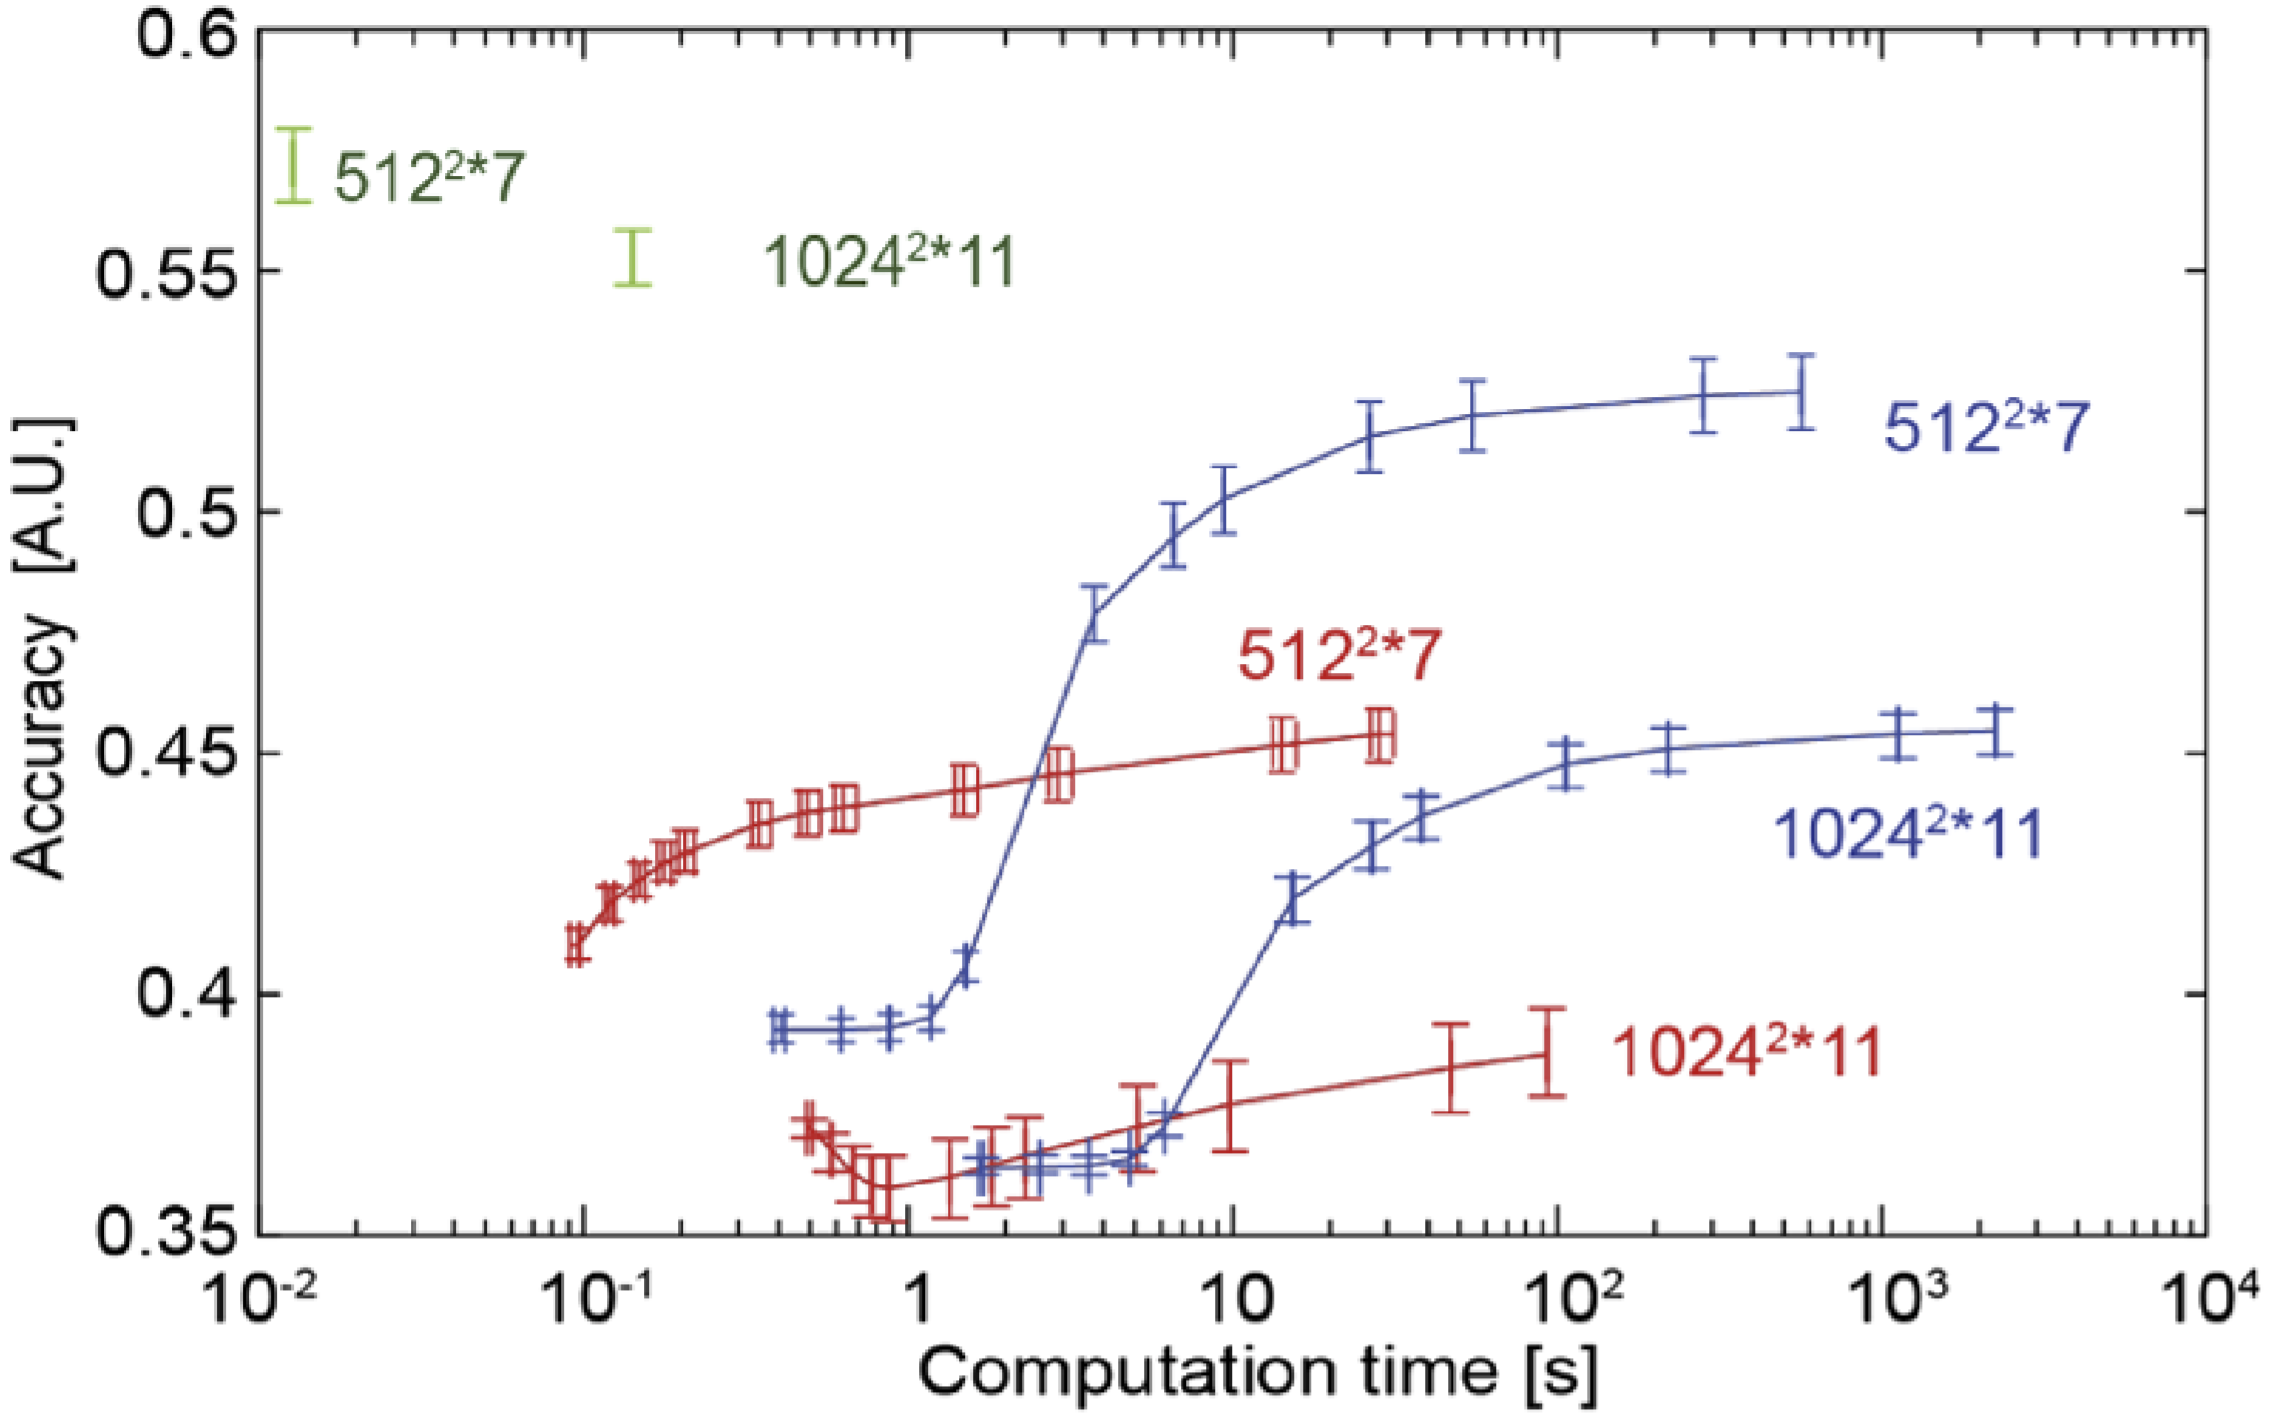